<h1>Currently working in it...... # 12 January 2024</h1>
<br><h3>----This Notebook Contain Sample For 6 Parameter using COBAYA</h3>

In [2]:
#files to be imported
import numpy as np
from matplotlib import pyplot as plt

import os ,sys, platform
import time
import cosmopower as cp

import mpi4py
import cobaya
import emcee

In [2]:
#Planks Values
el = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 0, skiprows=1,dtype =float)
el_te = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 0, skiprows=1,dtype =float)
Dl_TT = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 1, skiprows=1,dtype =float)
Dl_TT_err_up = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 3, skiprows=1,dtype =float)
Dl_TT_err_bot = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 2, skiprows=1,dtype =float)
Dl_EE = np.loadtxt('planks/COM_PowerSpect_CMB-EE-full_R3.01.txt',usecols = 1, skiprows=1,dtype =float)
Dl_EE_err_up = np.loadtxt('planks/COM_PowerSpect_CMB-EE-full_R3.01.txt',usecols = 3, skiprows=1,dtype =float)
Dl_EE_err_bot = np.loadtxt('planks/COM_PowerSpect_CMB-EE-full_R3.01.txt',usecols = 2, skiprows=1,dtype =float)
Dl_TE = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 1, skiprows=1,dtype =float)
Dl_TE_err_up = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 3, skiprows=1,dtype =float)
Dl_TE_err_bot = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 2, skiprows=1,dtype =float)
#ells
dl_fac = el*(el+1)/(2*np.pi)
dl_fac_te = el_te*(el_te+1)/(2*np.pi)
#COSMOPOWER
tt_emu = cp.cosmopower_NN(restore=True,restore_filename='COSMO/cmb_TT_NN')
ee_emu = cp.cosmopower_NN(restore=True,restore_filename='COSMO/cmb_EE_NN')
te_emu = cp.cosmopower_PCAplusNN(restore=True,restore_filename='COSMO/cmb_TE_PCAplusNN')

In [3]:
def chi2(tre,teu,trb,pred): #chi^2 model
    #c = ((tre - pred)**2)/((pred)**2)
    c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2
    chi = np.sum(c)
    return chi

#time ms to order of time
def time_hr(ms):
    ssm = ms*100
    seconds = int(ssm/100)
    minutes = int(seconds/60)
    hours = int(minutes/60)
    days = int(hours/24)
    sm = int(ssm - seconds*100)
    s = seconds - minutes*60 
    m = minutes - hours*60
    h = hours - days*24
    t = [sm,s,m,h,days]
    xi = ''
    if days == h == m == s == 0 :
        xi = str(sm) +'ms '
    elif days == h == m == 0:
        xi = str(s) +'s ' + str(sm) +' ms'
    elif days == h == 0:
        xi = str(m) + ' min ' + str(s) +'s ' + str(sm) +' ms'
    elif days == 0:
        xi = str(h) + 'hrs '+str(m) + 'min '+str(s) +'s ' + str(sm) +' ms'
    else :
        xi = str(days) +'days ' + str(h) + 'hrs '+str(m) + 'min '+str(s) +'s ' + str(sm) +' ms' 
    return xi #time 

def Find_val(inputrange,array):
    #finding the input value for the  minimum chi2 value
    min_chi2 = np.argmin(array) #position of minimum chi2
    vals = inputrange[min_chi2] #finding Input value of minimum chi2
    return vals

def Cosmo(xe,ze): # function for Cosmopower
    if xe == 'TT':
        tt_spectra = tt_emu.ten_to_predictions_np(ze)
        CO = tt_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2
    elif xe == 'EE':
        ee_spectra = ee_emu.ten_to_predictions_np(ze)
        CA = ee_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2
        CO = CA[:1995] #since planks data as only 1995 values 
    elif xe == 'TE':
        te_spectra = te_emu.predictions_np(ze)
        CA = te_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2
        CO = CA[:1995] #since planks data as only 1995 values 
    else:
        Print('Check Input Range or Data')
    return CO

def Cosmo_Power(omb,omc,h,tau,ns,As): #function for single value cosmopower
    DET = 'TT'
    params = {'omega_b': [omb],'omega_cdm': [omc],'h': [h/100],'tau_reio': [tau],'n_s': [ns],'ln10^{10}A_s': [np.log( 10**10 *(As*1e-9) )],}
    Para = [omb,omc,h,tau,ns,As]
    if DET=='TT':
        pred = Cosmo('TT',params)*dl_fac
        chi = chi2(Dl_TT*dl_fac,Dl_TT_err_up*dl_fac,Dl_TT_err_bot*dl_fac,pred*dl_fac)
    elif DET=='TE':
        pred = Cosmo('TE',params)*dl_fac_te
        chi = chi2(Dl_TE,Dl_TE_err_up,Dl_TE_err_bot,pred)
    elif DET=='EE':
        pred = Cosmo('EE',params)*dl_fac_te
        chi = chi2(Dl_EE,Dl_EE_err_up,Dl_EE_err_bot,pred)
    reference = [omb,omc,h,tau,ns,As,chi]
    return chi #parameter, prediction , chi value

In [4]:
print(Cosmo_Power(0.022,0.12,68,0.0546,0.964,2.01))

930.6118509511323


In [6]:
# below is parameters for 6 parameter cosmopower
info = {"likelihood": {"ring": Cosmo_Power}}
info["params"] = {
    "omb": {"prior": {"min": 0.001, "max": 0.08}, "ref": 0.022, "proposal": 0.005},
    "omc": {"prior": {"min": 0, "max": 0.5}, "ref": 0.12, "proposal": 0.05},
    "h": {"prior": {"min": 50, "max": 80}, "ref": 66, "proposal": 0.5},
    "tau": {"prior": {"min": 0.01, "max": 0.08}, "ref": 0.054, "proposal": 0.005},
    "ns": {"prior": {"min": 0.3, "max": 1.5}, "ref": 0.945, "proposal": 0.05},
    "As": {"prior": {"min": 1.5, "max": 2.5}, "ref": 2.0196, "proposal": 0.05}}
info["sampler"] = {"mcmc": {"Rminus1_stop": 0.001, "max_tries": 1000}}

In [ ]:
from cobaya import run
updated_info, sampler = run(info)

[mcmc] *WARNING* When combining chains, it is recommended to remove some initial fraction, e.g. 'skip_samples=0.3'
(130320,)


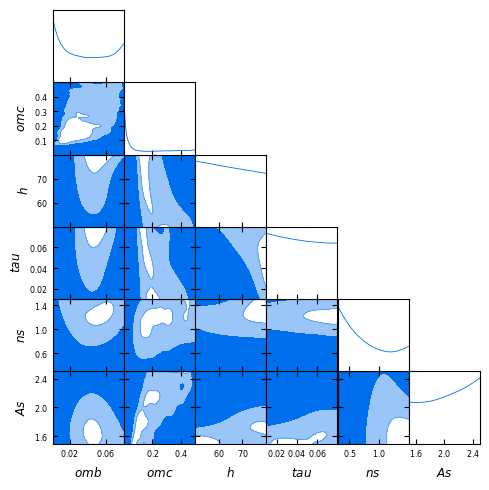

In [46]:
%matplotlib inline
import getdist.plots as gdplt

gdsamples = sampler.products(to_getdist=True)["sample"]
gdplot = gdplt.get_subplot_plotter(width_inch=5)
gdplot.triangle_plot(gdsamples, ["omb", "omc","h","tau","ns","As"], filled=True)
print(np.shape(gdsamples[7]))

Creating array of parameters with multiple combinations


In [5]:
#varing 6 parameters
omb_min = 0.01
omb_max = 0.04
omc_min = 0.01
omc_max = 0.4
h_min = 50
h_max = 90
tau_min = 0.01
tau_max = 0.09
ns_min = 0.3
ns_max = 1.5
As_min = 1.5
As_max = 3
Varying = 0.1

parameter_array=[]
def Variable(max,min,var):
    return ((max-min)*var)
Parameter_vari = [[omb_max,omb_min,Variable(omb_max,omb_min,Varying)],
                 [omc_max,omc_min,Variable(omc_max,omc_min,Varying)],
                 [h_max,h_min,Variable(h_max,h_min,Varying)],
                 [tau_max,tau_min,Variable(tau_max,tau_min,Varying)],
                 [ns_max,ns_min,Variable(ns_max,ns_min,Varying)],
                 [As_max,As_min,Variable(As_max,As_min,Varying)]]
def array_generator(Par_var):
    para_array = []
    for i in np.arange(Par_var[0][1],Par_var[0][0],Par_var[0][2]):
        for j in np.arange(Par_var[1][1],Par_var[1][0],Par_var[1][2]):
            for k in np.arange(Par_var[2][1],Par_var[2][0],Par_var[2][2]):
                for l in np.arange(Par_var[3][1],Par_var[3][0],Par_var[3][2]):
                    for m in np.arange(Par_var[4][1],Par_var[4][0],Par_var[4][2]):
                        for n in np.arange(Par_var[5][1],Par_var[5][0],Par_var[5][2]):
                            ss = [i,j,k,l,m,n]
                            para_array.append(ss)
                            
    return para_array

array_geb = array_generator(Parameter_vari)
print(np.shape(array_geb))

(1000000, 6)


#finding parameter using a walker methode where finding chi sq randomly for a range and setting lowest values as range and again till n times

In [8]:
def iterator(sample,Var,array):
    rando = []
    number = np.shape(array)[0]
    low_par_arr = [[],[],[],[],[],[]]
    sample = sample
    counter = 0
    low_chi_sq = np.inf
    low_chi_par = []
    
    if sample != counter:
        for i in range(0,sample):
            counter =counter +1
            ran = np.random.randint(number)
            try:
                rando.index(ran)
            except:
                ran = np.random.randint(number)
            rando.append(ran)
            

        eq_num = np.linspace(0,number,6000)[:-1]
        for i in eq_num:
            #print(int(i))
            try:
                rando.index(int(i))
            except:
                rando.append(int(i))
        for j in rando:
            par = array[j]
            chi = Cosmo_Power(par[0],par[1],par[2],par[3],par[4],par[5])
            if chi <= low_chi_sq:
                low_chi_sq = chi
                low_chi_par = par
            else:
                None
            if chi <= low_chi_sq:
                for i in range(6):
                    low_par_arr[i].append(par[i])
            else:
                None
    else:
        None
    print(np.shape(rando))
    ret_par = []
    for i in range(6):
        if np.max(low_par_arr[i]) == np.min(low_par_arr[i]):
            per =  np.max(low_par_arr[i])*(10/100)
            xx = np.max(low_par_arr[i]) + per
            yy = np.min(lw_par_arr[i]) + per
            ret_par.append([xx,yy,Variable(xx,yy,Var)])
        else:
            ret_par.append([np.max(low_par_arr[i]),np.min(low_par_arr[i]),Variable(np.max(low_par_arr[i]),np.min(low_par_arr[i]),Var)])
    
    return [low_chi_sq,low_chi_par,ret_par]

def walker(sample,walker,var,par):
    pare = par
    chi = []
    chi_ara = []
    for i in range(walker):
        array = array_generator(pare)
        ite = iterator(sample,var,array)
        chi.append(ite[0])
        chi_ara.append(ite[1])
        pare = ite[2]
        pare2 = [np.round(ite[2][0],decimals = 6),np.round(ite[2][1],decimals = 6),np.round(ite[2][2],decimals = 6),np.round(ite[2][3],decimals = 6),np.round(ite[2][4],decimals = 6),np.round(ite[2][5],decimals = 6)]
        #print(pare)
    return [chi_ara[-1]]

In [25]:
walker(10000,10,0.1,Parameter_vari)

(15940,)
(15953,)
(15937,)
(15948,)
(15942,)
(15939,)
(15936,)
(15941,)
(15938,)
(15929,)


[[0.021591700479999986,
  0.132998498272,
  62.261061120000065,
  0.024481575936000005,
  0.9390102240000007,
  2.0388883199999994]]

In [9]:
def brute_force(array):
    reference = [[],[],[],[],[],[],[]]
    for i in array:
        chi = Cosmo_Power(i[0],i[1],i[2],i[3],i[4],i[5])
        for j in range(6):
            reference[j].append(i[j])
        reference[6].append(chi)
    least_par = [Find_val(reference[0],reference[6]),
                 Find_val(reference[1],reference[6]),
                 Find_val(reference[2],reference[6]),
                 Find_val(reference[3],reference[6]),
                 Find_val(reference[4],reference[6]),
                 Find_val(reference[5],reference[6]),]
    return least_par,reference

In [10]:
st = time.time()
rei = brute_force(array_geb)
#np.save('likeliyhood/chi_arr/chi_arr_6_parameter_1milion_'+'time.date',rei[1])
ed = time.time()
print(time_hr(ed-st))
print(rei[0]) 

1hrs 19min 3s 73 ms
[0.025000000000000005, 0.08800000000000001, 86.0, 0.05000000000000001, 1.02, 1.9499999999999997]


In [13]:
ndim  = 6
nsample = 1000
sample = ["omb","omc","H","Tau_Reio","Ns","ln10^10As"]

In [3]:
st = np.load('likeliyhood/chi_arr/chi_arr_6_parameter_1milion.npy')[6]

In [6]:
pv= Parameter_vari
omb = np.arange(pv[0][1],pv[0][0],pv[0][2])
omc = np.arange(pv[1][1],pv[1][0],pv[1][2])
h = np.arange(pv[2][1],pv[2][0],pv[2][2])
tau = np.arange(pv[3][1],pv[3][0],pv[3][2])
ns = np.arange(pv[4][1],pv[4][0],pv[4][2])
As = np.arange(pv[5][1],pv[5][0],pv[5][2]) 

ste = np.reshape(st,(np.shape(omb)[0],np.shape(omc)[0],np.shape(h)[0],np.shape(tau)[0],np.shape(ns)[0],np.shape(As)[0]))

In [11]:
print(np.shape(ste))

(10, 10, 10, 10, 10, 10)


In [21]:
likeli_para_omb = np.mean(ste,axis=(1,2,3,4,5))
likeli_para_omc = np.mean(ste,axis=(0,2,3,4,5))
likeli_para_h = np.mean(ste,axis=(0,1,3,4,5))
likeli_para_tau = np.mean(ste,axis=(0,1,2,4,5))
likeli_para_ns = np.mean(ste,axis=(0,1,2,3,5))
likeli_para_as = np.mean(ste,axis=(0,1,2,3,4))
ll = [likeli_para_omb,likeli_para_omc,likeli_para_h,likeli_para_tau,likeli_para_ns,likeli_para_as]

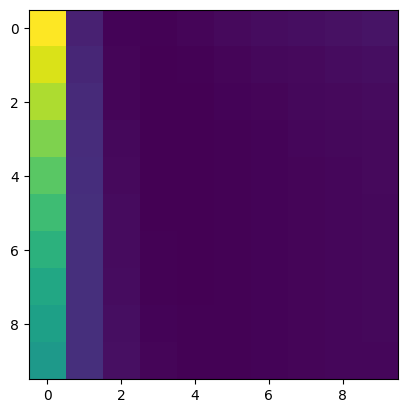

In [17]:
pars_aray = [['omc','omb'],
        ['h','omb'],  ['h','omc'],
        ['tau','omb'],['tau','omc'],['tau','h'],
        ['ns','omb'], ['ns','omc'], ['ns','h'], ['ns','tau'],
        ['as','omb'], ['as','omc'], ['as','h'], ['as','tau'],['as','ns']]
likeli_para_omc_omb = np.mean(ste,axis=(2,3,4,5))
likeli_para_h_omb = np.mean(ste,axis=(1,3,4,5))
likeli_para_h_omc = np.mean(ste,axis=(0,3,4,5))
likeli_para_tau_omb = np.mean(ste,axis=(1,2,4,5))
likeli_para_tau_omc = np.mean(ste,axis=(0,2,4,5))
likeli_para_tau_h = np.mean(ste,axis=(0,1,4,5))
likeli_para_ns_omb = np.mean(ste,axis=(1,2,3,5))
likeli_para_ns_omc = np.mean(ste,axis=(0,2,3,5))
likeli_para_ns_h = np.mean(ste,axis=(0,1,3,5))
likeli_para_ns_tau = np.mean(ste,axis=(0,1,2,5))
likeli_para_as_omb = np.mean(ste,axis=(1,2,3,4))
likeli_para_as_omc = np.mean(ste,axis=(0,2,3,4))
likeli_para_as_h = np.mean(ste,axis=(0,1,3,4))
likeli_para_as_tau = np.mean(ste,axis=(0,1,2,4))
likeli_para_as_ns = np.mean(ste,axis=(0,1,2,3))
lll = [likeli_para_omc_omb,
       likeli_para_h_omb,likeli_para_h_omc,
       likeli_para_tau_omb,likeli_para_tau_omc,likeli_para_tau_h,
       likeli_para_ns_omb,likeli_para_ns_omc,likeli_para_ns_h,likeli_para_ns_tau,
       likeli_para_as_omb,likeli_para_as_omc,likeli_para_as_h,likeli_para_as_tau,likeli_para_as_ns]
plt.imshow(likeli_para_omc_omb)

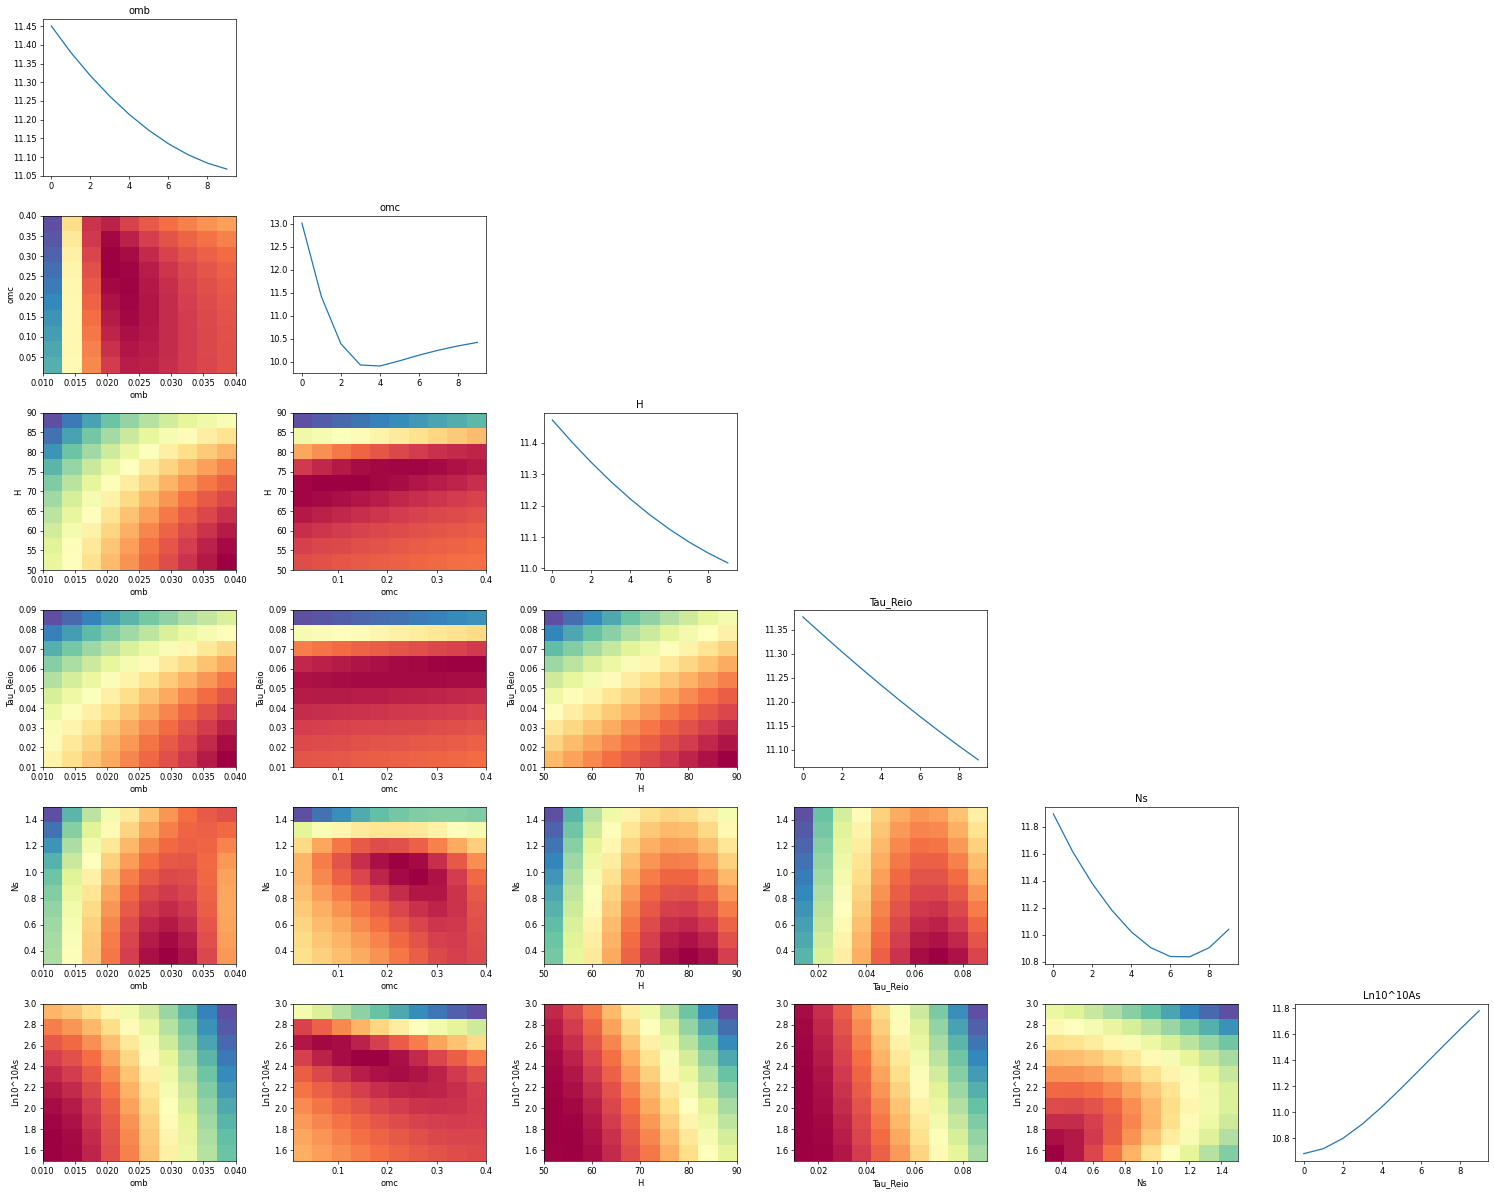

In [45]:
sample = ["omb","omc","H","Tau_Reio","Ns","Ln10^10As"]
index_aray = [[1,0],
              [2,0],  [2,1],
              [3,0],[3,1],[3,2],
              [4,0], [4,1], [4,2], [4,3],
              [5,0], [5,1], [5,2], [5,3],[5,4],]
s_Ar = [[0,0],[1,1],[2,2],[3,3],[4,4],[5,5]]

fig,axs = plt.subplots(6,6,figsize=(25,20),dpi=60)

y_ar = np.rot90(np.rot90(index_aray))
    
for j in y_ar:
    axs[j[0],j[1]].set_visible(False)

for i in range(np.shape(s_Ar)[0]):
    axs[s_Ar[i][0],s_Ar[i][1]].set_title(sample[i])
    axs[s_Ar[i][0],s_Ar[i][1]].plot(np.log(ll[i]))

for i in range(np.shape(index_aray)[0]):
    extent = (pv[index_aray[i][1]][1],pv[index_aray[i][1]][0],pv[index_aray[i][0]][1],pv[index_aray[i][0]][0])
    axs[index_aray[i][0],index_aray[i][1]].set_ylabel(sample[index_aray[i][0]])
    axs[index_aray[i][0],index_aray[i][1]].set_xlabel(sample[index_aray[i][1]])
    axs[index_aray[i][0],index_aray[i][1]].imshow(np.log(lll[i]),aspect='auto',cmap=plt.cm.Spectral,extent = extent)

plt.tight_layout()
plt.savefig('parameter_array_6_parameter')
plt.show()

In [53]:
for i in range(len(pv)):
    print('length of',sample[i],'is',len(np.arange(pv[i][1],pv[i][0],pv[i][2])))

length of omb is 10
length of omc is 10
length of H is 10
length of Tau_Reio is 10
length of Ns is 10
length of Ln10^10As is 10
